<a href="https://colab.research.google.com/github/ayberkozcan/pytorch-computer-vision/blob/main/Object_Classification_with_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Classification with CIFAR-10

In this notebook, we are going to load the CIFAR-10 dataset, use some pretrained models, and compare their performance.

## Importing Libraries

In [2]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}\nTorchvision version: {torchvision.__version__}")

PyTorch version: 2.5.1+cu124
Torchvision version: 0.20.1+cu124


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Downloading CIFAR-10 Dataset

In [5]:
train_data = datasets.CIFAR10(
    root="data",
    train=True,
    transform=ToTensor(),
    target_transform=None,
    download=True
)
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    transform=ToTensor(),
    download=True
)

Files already downloaded and verified
Files already downloaded and verified


## Exploring our Dataset

In [6]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(50000, 50000, 10000, 10000)

There are 50.000 training samples and 10.000 testing samples.

In [8]:
# Let's see classes
class_names = train_data.classes

print(f"Class shape: {len(class_names)}")
print(f"Classes\n{class_names}")

Class shape: 10
Classes
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Image shape: torch.Size([3, 32, 32])


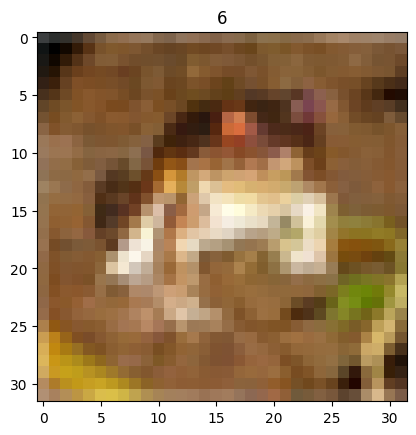

In [10]:
# Let's see a sample and learn its shape
image, label = train_data[0]

print(f"Image shape: {image.shape}")
plt.imshow(image.permute(1, 2, 0))
plt.title(label)
plt.show()

We changed the shape from (3, 32, 32) to (32, 32, 3), making it compatible with imshow.

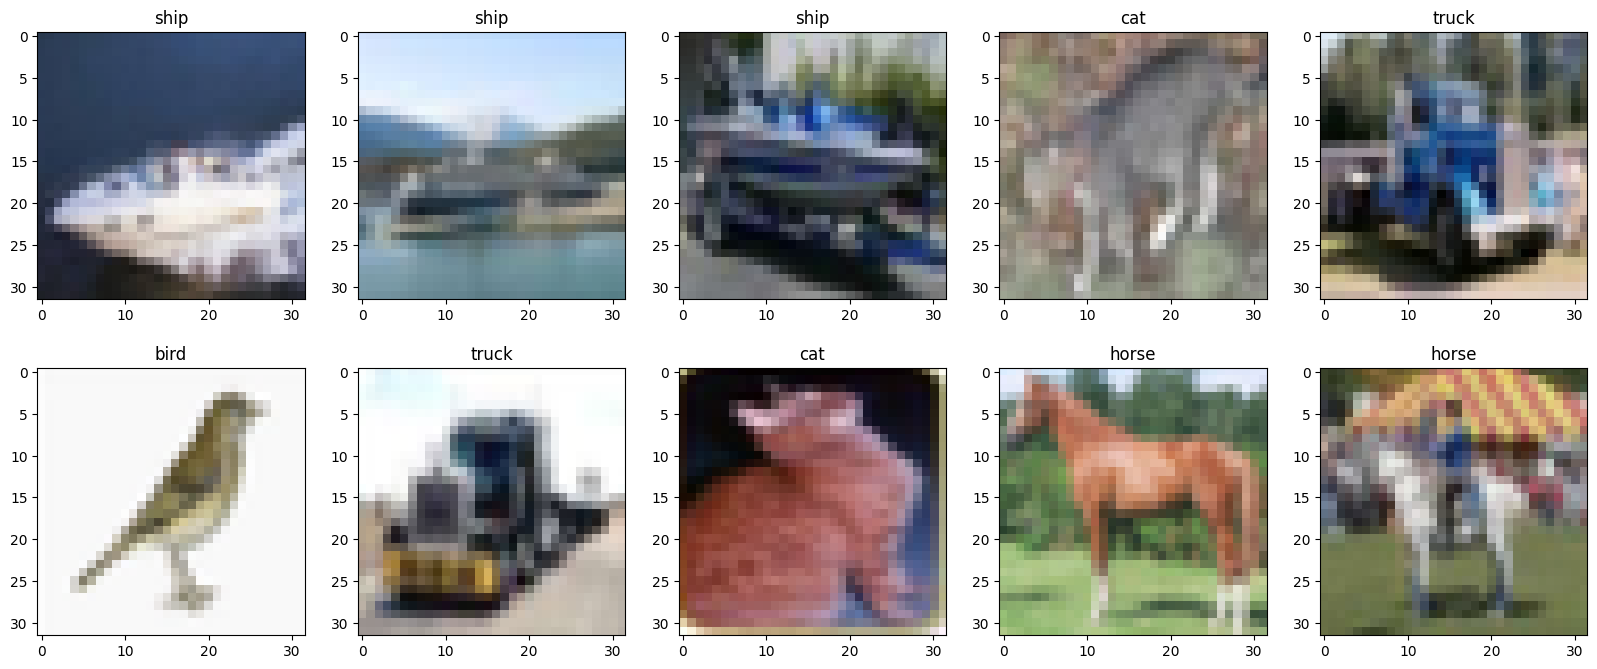

In [16]:
# Let's plot more images to explore our data
fig = plt.figure(figsize=(20, 8))
rows, cols = 2, 5
for i in range(1, rows * cols + 1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  image, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(image.permute(1, 2, 0))
  plt.title(class_names[label])

plt.show()

## Data Augmentation

We might augment our data a little to improve model performance when classifying more challenging images.

In [38]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

In [39]:
train_data_transformed = datasets.CIFAR10(
    root="data",
    train=True,
    transform=transform,
    target_transform=None,
    download=True
)
test_data_transformed = datasets.CIFAR10(
    root="data",
    train=False,
    transform=transform,
    download=True
)

Files already downloaded and verified
Files already downloaded and verified


Image shape: torch.Size([3, 32, 32])


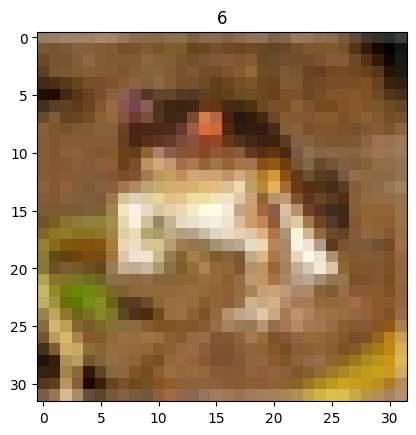

In [40]:
# Let's see a sample and learn its shape
image, label = train_data_transformed[0]

print(f"Image shape: {image.shape}")
plt.imshow(image.permute(1, 2, 0))
plt.title(label)
plt.show()

## Preparing Data with DataLoader

In [41]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = 1

train_dataloader = DataLoader(
    train_data_transformed,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True
)
test_dataloader = DataLoader(
    test_data_transformed,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

In [42]:
print(f"Length of train dataloader: {len(train_dataloader)}")
print(f"Length of test dataloader: {len(test_dataloader)}")

Length of train dataloader: 1563
Length of test dataloader: 313
